# $\vec{\mu}_t$ method with synthetic data
This notebook benchmarks the random walk based growth rate model on a synthetic dataset.

Specifically it runs the model with different settings for the `drift_scale`, demonstrating its effect on the result.

In [1]:
import ipywidgets
from matplotlib import cm, pyplot
import pandas
import pathlib
import arviz
import pathlib
import pymc3
import numpy
import copy
import scipy.stats

import bletl
import bletl.growth
import calibr8

# Some code was outsourced to sister files
import models
import plotting

DP_DATA = pathlib.Path("..", "data")
DP_RESULTS = pathlib.Path("..", "results")

## Generating synthetic data
In the following cell synthetic data is created from an artificial growth rate curve exhibiting a drift and multiple switchpoints.

The observations are drawn from the distribution of measurement outcomes predicted by a BioLector calibration model from the [calibr8-paper](https://github.com/JuBiotech/calibr8-paper).

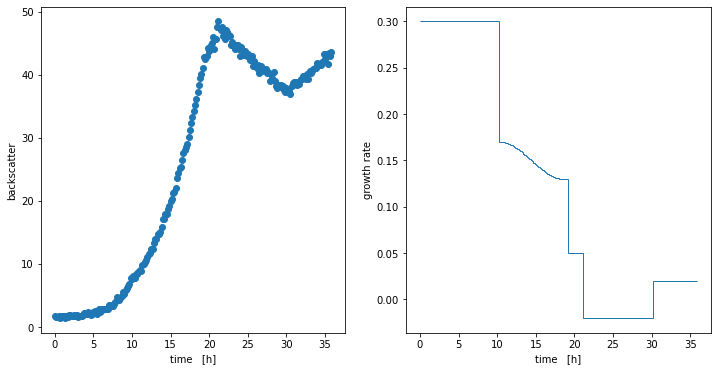

In [2]:
# The calibration model helps to simulate measurements
cm_cdw = models.get_biomass_calibration()

# Data rate at 1 per 10 minutes
t = numpy.arange(0, 36, step=10/60)   # time values of data points
ts = t[:-1]                           # left borders of growth rate intervals
mu_true = numpy.empty(len(ts))
mu_true[ts <= 10] = 0.3
#mu_true[ts > 10] = 0.15
mu_true[ts > 10] = 0.15 + 0.02 * numpy.cos(numpy.arange(0, sum(ts > 10)) / 16)
mu_true[ts > 19] = 0.05
mu_true[ts > 21] = -0.02
mu_true[ts > 30] = 0.02

# Simulate the biomass concentrations
X0_true = 0.25
X = numpy.concatenate([
    [X0_true],
    X0_true * numpy.exp(numpy.cumsum(mu_true * numpy.diff(t)))
])

# And draw backscatter observations according to the calibration model
loc, scale, df = cm_cdw.predict_dependent(X)
bs = scipy.stats.t.rvs(loc=loc, scale=scale, df=df)

assert t.shape == bs.shape

fig, axs = pyplot.subplots(ncols=2, figsize=(12, 6))

ax = axs[0]
ax.scatter(t, bs)
ax.set(
    ylabel="backscatter",
    xlabel="time   [h]",
)

ax = axs[1]
ax.stairs(mu_true, t, baseline=None)
ax.set(
    ylabel="growth rate",
    xlabel="time   [h]",
)
pyplot.show()

# Apply the $\vec{\mu}_t$ method
The next cell runs optimization and MCMC of the $\vec{\mu}_t$ model with different settings for the `drift_scale`.

The `drift_scale` parameter controls how "stable" the growth rate is expected to be.

A large `drift_scale` corresponds to the assumption that growth rate is unstable and accordingly the model will describe a more fluctuating growth rate with broader uncertainties.

A small `drift_scale` encode the assumption that the growth rate is very stable over time. With $\lim_{\mathrm{drift\_scale}\to 0} f(x)$ the random walk converges to a constant growth rate.
In the extreme case the model would become a (computationally expensive) exponential function with one growth rate and narrow uncertainties.

In [3]:
results = {}

for sigma in [0.001, 0.0025, 0.005, 0.01]:
    result = bletl.growth.fit_mu_t(
        t, bs,
        cm_cdw,
        mu_prior=0.3,
        drift_scale=sigma,
    )
    fp_trace = pathlib.Path(f"synthetic_sigma_{sigma:.4f}.nc")
    if not fp_trace.exists():
        print("Sampling...")
        result.sample(tune=2000, draws=1000, target_accept=0.95)
        result.idata.to_netcdf(fp_trace)
    else:
        print("Loading from disk...")
        result._idata = arviz.from_netcdf(fp_trace)
    results[sigma] = result

C:\Users\osthege\AppData\Local\Continuum\miniconda3\envs\bletl_env\lib\site-packages\calibr8\core.py:746: RuntimeWarning: invalid value encountered in power
  x_hat = - (x1**(-x1*x3) * numpy.log( ((1/y)**x0 - 1) * numpy.exp(-x0*x4+x2-x4) ) ) / s



Sampling...


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [X0, mu_t__diff_]


Sampling 3 chains for 2_000 tune and 1_000 draw iterations (6_000 + 3_000 draws total) took 620 seconds.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
C:\Users\osthege\AppData\Local\Continuum\miniconda3\envs\bletl_env\lib\site-packages\calibr8\core.py:746: RuntimeWarning: invalid value encountered in power
  x_hat = - (x1**(-x1*x3) * numpy.log( ((1/y)**x0 - 1) * numpy.exp(-x0*x4+x2-x4) ) ) / s



Sampling...


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [X0, mu_t__diff_]


Sampling 3 chains for 2_000 tune and 1_000 draw iterations (6_000 + 3_000 draws total) took 618 seconds.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.
C:\Users\osthege\AppData\Local\Continuum\miniconda3\envs\bletl_env\lib\site-packages\calibr8\core.py:746: RuntimeWarning: invalid value encountered in power
  x_hat = - (x1**(-x1*x3) * numpy.log( ((1/y)**x0 - 1) * numpy.exp(-x0*x4+x2-x4) ) ) / s



Sampling...


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [X0, mu_t__diff_]


Sampling 3 chains for 2_000 tune and 1_000 draw iterations (6_000 + 3_000 draws total) took 612 seconds.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.
C:\Users\osthege\AppData\Local\Continuum\miniconda3\envs\bletl_env\lib\site-packages\calibr8\core.py:746: RuntimeWarning: invalid value encountered in power
  x_hat = - (x1**(-x1*x3) * numpy.log( ((1/y)**x0 - 1) * numpy.exp(-x0*x4+x2-x4) ) ) / s



Sampling...


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [X0, mu_t__diff_]


Sampling 3 chains for 2_000 tune and 1_000 draw iterations (6_000 + 3_000 draws total) took 609 seconds.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
C:\Users\osthege\AppData\Local\Continuum\miniconda3\envs\bletl_env\lib\site-packages\calibr8\core.py:746: RuntimeWarning: invalid value encountered in power
  x_hat = - (x1**(-x1*x3) * numpy.log( ((1/y)**x0 - 1) * numpy.exp(-x0*x4+x2-x4) ) ) / s



Sampling...


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [X0, mu_t__diff_]


Sampling 3 chains for 2_000 tune and 1_000 draw iterations (6_000 + 3_000 draws total) took 609 seconds.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


## Show the results with the logistic model separately
This first visualization compares the full posterior obtained by MCMC with the MAP estimate obtained by optimization.

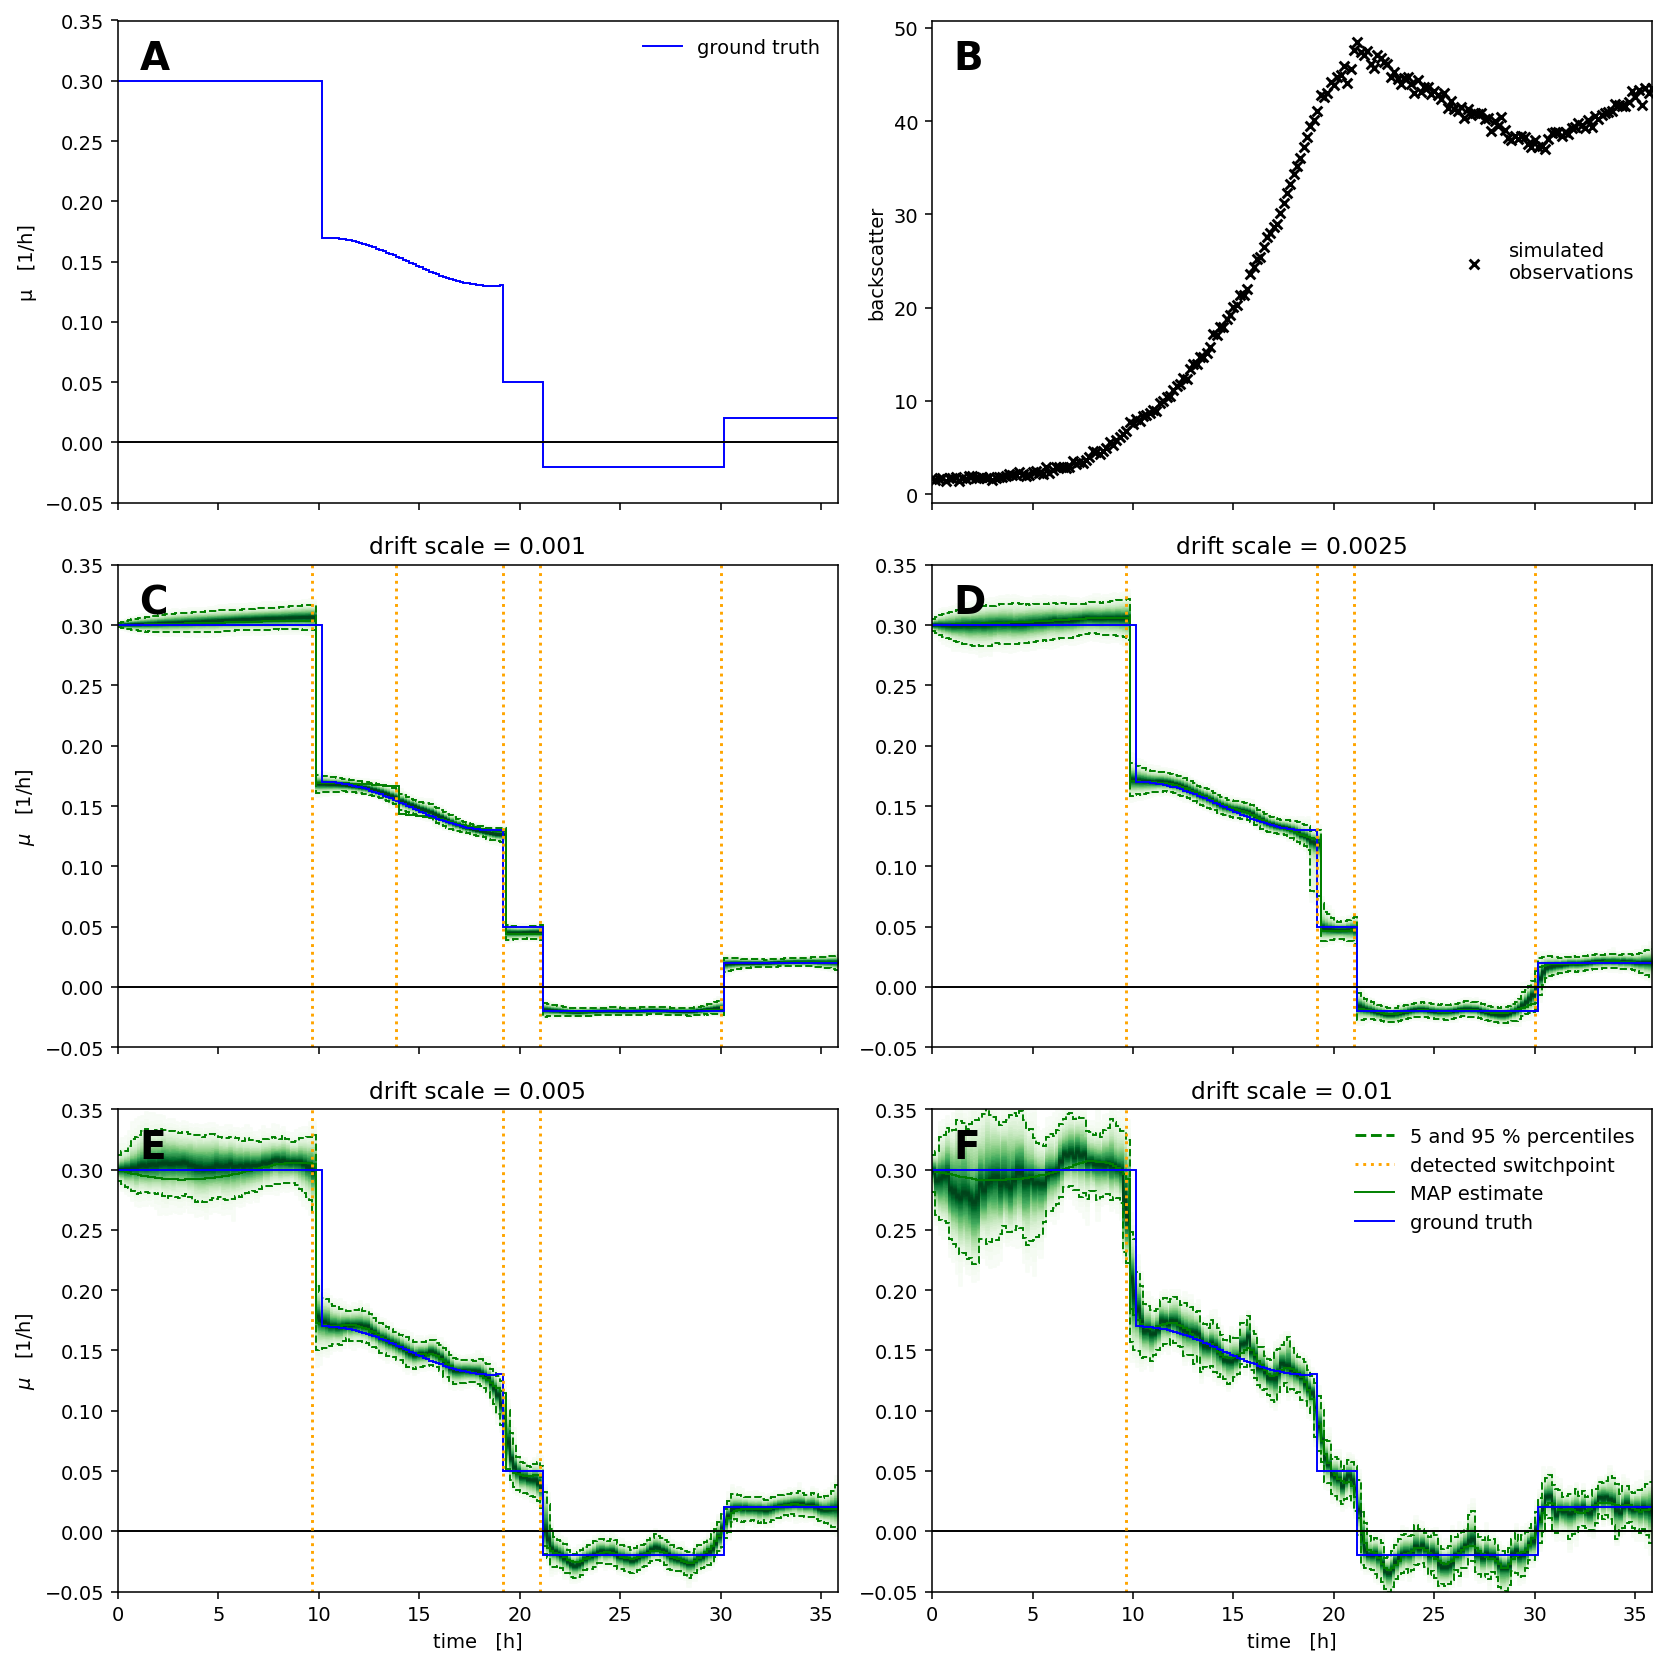

In [43]:
def plot_x(ax, result):
    plotting.plot_density(
        ax=ax,
        x=result.t_data,
        samples=result.x_mcmc,
        plot_samples=False,
        palette=cm.Greens,
        percentile_kwargs=dict(color="green")
    )
    ax.scatter(t, cm_cdw.predict_independent(bs), s=25, label='$y_{cal}$', marker='x', color='black')
    ax.set(
        ylabel="X   [g/L]",
        xlabel="time   [h]",
        ylim=(0, None),
    )
    ax.legend(loc="center left", frameon=False)
    return
    
    
def plot_switchpoints(ax, result, with_text: bool):
    # draw vertical lines at switchpoints
    for t_switch, label in result.switchpoints.items():
        ax.axvline(t_switch, linestyle=':', color='orange', label=label + " switchpoint")
        if with_text:
            ax.text(
                t_switch, 1,
                s=f'{label}\n',
                color="gray",
                rotation=90,
                horizontalalignment="center",
                verticalalignment='bottom',
            )
    return


def plot_mu(ax, result, legend=True):
    ax.axhline(0, color="black", lw=1)
    plotting.plot_density(
        ax=ax,
        x=result.t_data,
        samples=result.mu_mcmc,
        plot_samples=False,
        palette=cm.Greens,
        percentile_kwargs=dict(color="green")
    )
    ax.stairs(result.mu_map, result.t_data, color='green', label='MAP estimate', baseline=None)

    ax.stairs(mu_true, result.t_data, color="blue", label="ground truth", baseline=None)
    ax.plot([], [], ls="--", color="green", label="5 and 95 % percentiles")
    return


fig, axs = pyplot.subplots(ncols=2, nrows=3, figsize=(12, 12), dpi=140, sharex=True)

ax = axs[0,0]
ax.axhline(0, color="black", lw=1)
ax.stairs(mu_true, t, color="blue", baseline=None, label="ground truth")
ax.set(
    ylim=(-0.05, 0.35),
    ylabel="µ   [1/h]",
)
ax.legend(frameon=False, loc="upper right")

ax = axs[0,1]
ax.scatter(t, bs, s=25, marker='x', color='black', label="simulated\nobservations")
ax.set(
    ylabel="backscatter",
)
ax.legend(frameon=False, loc="center right")

for r, (sigma, result) in enumerate(results.items()):
    ax = axs.flatten()[2+r]
    plot_mu(ax, result)
    plot_switchpoints(ax, result, with_text=False)
    ax.set(
        ylim=(-0.05, 0.35),
        xlabel="time   [h]" if ax in axs[-1, :] else "",
        ylabel="$\mu$   [1/h]" if ax in axs[:, 0] else "",
    )
    ax.set_title(f"drift scale = {sigma}")
axs[-1, -1].legend(frameon=False, loc="upper right")

for ax, letter in zip(axs.flatten(), "ABCDEF"):
    ax.text(0.03, 0.90, letter, transform=ax.transAxes, size=20, weight="bold")
    ax.set_xlim(0, t[-1])

fig.tight_layout()
fig.savefig(DP_RESULTS / "fig_mut_synthetic.pdf", bbox_inches="tight")
fig.savefig(DP_RESULTS / "fig_mut_synthetic.png", bbox_inches="tight")
pyplot.show()

In [5]:
%load_ext watermark
%watermark

Last updated: 2021-08-19T22:26:49.866020+02:00

Python implementation: CPython
Python version       : 3.7.9
IPython version      : 7.26.0

Compiler    : MSC v.1916 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 158 Stepping 10, GenuineIntel
CPU cores   : 6
Architecture: 64bit

